# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
m = nn.Conv1d(16, 33, 3)
input = torch.randn(20, 16, 50)
print(input.shape)
output = m(input)
output.shape

torch.Size([20, 16, 50])


torch.Size([20, 33, 48])

# Config

## Model training config

In [2]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [4]:
# TODO: Load read and load the data here
df = pd.read_csv('twitter-suicidal-data.csv')
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Preprocessing

In [5]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\javadpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
import re

# Sample text
text = "Follow @user1 @gholi and @user2 for updates."

# Regex pattern to match words starting with @
pattern = re.compile(r'@\w+')

# Find all matches in the text
matches = pattern.findall(text)

print("Matches:", matches)


Matches: ['@user1', '@gholi', '@user2']


In [7]:
def convert_emoji_to_text(text):
  emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F1E0-\U0001F1FF'  # flags (iOS)
        '\U00002700-\U000027BF'  # dingbats
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U00002600-\U000026FF'  # Miscellaneous Symbols
        '\U0001F018-\U0001F270'  # Various Asian characters
        '\U0001F004-\U0001F0CF'  # Playing cards
        '\U0001F0A0-\U0001F0FF'  # Playing cards continued
        '\U00002B50-\U00002B50'  # Stars
        '\U0001F004-\U0001F004'  # Mahjong tile
        '\U0001F0CF-\U0001F0CF'  # Joker
        '\U0001F170-\U0001F251'  # Enclosed characters
        '\U0001F004-\U0001F0CF'  # More Mahjong tiles
        '\U00002B06-\U00002B07'  # Arrows
        ']+'
    )
  return emoji_pattern.sub(" ", text)


stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # TODO: lowercase the text
    text = text.lower()
    # TODO: remove usernames
    text = re.sub(r'@\w+', ' ', text)
    # TODO: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # TODO: remove numbers
    text = re.sub(r'-?\b\d+(\.\d+)?\b', '', text)
    # TODO: remove urls,
    text = re.sub(r'\b(?:http://|https://|www\.|http)[^/\s]+\b', '', text)
    # TODO: remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # TODO: convert emojis to text
    text = convert_emoji_to_text(text)
    # TODO: remove non-word characters
    text = re.sub(r'\W+', ' ', text)
    # TODO: lemmatization and tokenization of the text
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in pos_tags]
    # TODO: remove stopwords
    tokens = [token for token in lemmatized_tokens if token.lower() not in stopwords]
    return tokens


In [8]:
## TODO: Show some samples before/after preprocessing
# Sample test cases
test_cases = [
    # Basic test case
    "The quick brown fox jumps over the lazy dog.",

    # Test case with punctuation
    "Hello, world! This is a test.",

    # Test case with numbers
    "The price is $100.50.",

    # Test case with URLs
    "Visit our website at https://example.com for more information.",

    # Test case with usernames
    "Follow @user1 and @user2 for updates.",

    # Test case with emojis
    "I am feeling 😊 today!",

    # Test case with extra spaces
    "   This     is   a     test.   ",

    # Test case with stopwords
    "The quick brown fox jumps over the lazy dog."
]

# Print test cases and expected results
for i, text in enumerate(test_cases):
    print(f"Test Case {i+1}:")
    print("Text:", preprocess_data(text))
    print()


Test Case 1:
Text: ['quick', 'brown', 'fox', 'jump', 'lazy', 'dog']

Test Case 2:
Text: ['hello', 'world', 'test']

Test Case 3:
Text: ['price']

Test Case 4:
Text: ['visit', 'website', 'information']

Test Case 5:
Text: ['follow', 'update']

Test Case 6:
Text: ['feel', 'today']

Test Case 7:
Text: ['test']

Test Case 8:
Text: ['quick', 'brown', 'fox', 'jump', 'lazy', 'dog']



# Word2Vec - Word Embedding

In [9]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [10]:
W2V_PATH = "models"
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [11]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
# w2v_model['javad'] -> NA

# Dataset

In [12]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
        vectors = np.empty((64, 300))
        for idx, token in enumerate(tokens):
            if token in self.w2v_model:
                vectors[idx] = self.w2v_model[token]
            else:
                vectors[idx] = np.zeros(self.vector_size)
        return self._to_tensor(vectors)            

        # vectors = []
        # for token in tokens:
            # if token in self.w2v_model:
                # vectors.append(self.w2v_model[token])
            # else:
                # vectors.append(np.zeros(self.vector_size))
        # return self._to_tensor(vectors)


    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens) < self.max_sequence_len:
            tokens.extend(['javad'] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [15]:
t = Twitter(df, w2v_model, SEQUENCE_LEN)

Deleted 0-Len Samples: 31


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_20316\2011463332.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_20316\2011463332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [16]:
t.dataframe.head()

,tweet,intention,tokens,vector
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li...","[[tensor(-0.0679), tensor(0.0952), tensor(0.03..."
1,muttering i wanna die to myself daily for a fe...,1,"[mutter, wan, na, die, daily, month, feel, wor...","[[tensor(0.0952), tensor(-0.0138), tensor(0.25..."
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif...","[[tensor(-0.0757), tensor(0.0337), tensor(-0.0..."
3,i did something on the 2 of october i overdose...,1,"[something, october, overdose, felt, alone, ho...","[[tensor(0.1123), tensor(0.0183), tensor(0.077..."
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel...","[[tensor(-0.0557), tensor(0.0137), tensor(-0.1..."


# Prepare Data

## Split Data into train-valid

In [13]:
# TODO: Split dataset into train-test split
indexes = np.arange(len(df))
X_train_idx, X_test_idx = train_test_split(indexes, test_size=0.2, random_state=42)

## Create Datasets

In [14]:
# TODO: create twitter dataset
train_dataset = Twitter(
    df.iloc[X_train_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)
valid_dataset = Twitter(
    df.iloc[X_test_idx],
    w2v_model=w2v_model,
    sequence_len=SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Deleted 0-Len Samples: 23


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:35: SettingWithCopyWarning: 
A value is t

Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


C:\Users\javadpsk\AppData\Local\Temp\ipykernel_19432\2011463332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Model and Train

## Utils

In [15]:
# @torch.no_grad()
# def model_eval(model, loader, loss_function, device: str['cuda', 'cpu', 'auto']):
#     """Returns test_loss, test_acc"""
#     test_loss = 0.0
#     test_acc = 0.0

#     if device == "auto":
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     model = model.to(device)
#     itr = tqdm(loader, total=len(loader), leave=False)

#     for inputs, labels in itr:
#         # TODO: move model's inputs to `device`
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         # TODO: use model's forward pass to generate outputs
#         # TODO: calculate model's loss
#         # loss =

#         # TODO: calculate/update model's accuracy

#         itr.set_description("(Eval)")
#         itr.set_postfix(
#             loss=round(loss.item(), 5),
#             accuracy=round(test_acc, 5),
#         )

#     return test_loss, test_acc

@torch.no_grad()
def model_eval(model, loader, loss_function, device: str=('cuda', 'cpu', 'auto')):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move model's inputs to `device`
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Use model's forward pass to generate outputs
        outputs = model(inputs)
        
        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions = (predictions == labels).sum().item()
        test_acc += correct_predictions / labels.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc

In [16]:
# def train_model(
#         model,
#         batch_size,
#         loss_function,
#         optimizer,
#         epochs,
#         train_set,
#         valid_set,
#         device: str['cuda', 'cpu', 'auto'],
# ):

#     if device == "auto":
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     model.to(device)

#     train_losses = []
#     train_accs = []

#     valid_losses = []
#     valid_accs = []

#     # TODO: create dataloaders from datasets
#     # train_loader =
#     # valid_loader =

#     model.to(device)

#     itr = tqdm(train_loader, total=len(train_loader), leave=False)

#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0
#         epoch_acc = 0
#         for idx, (inputs, labels) in enumerate(itr, start=1):
#             # TODO: move model's inputs to `device`

#             # TODO: use model's forward pass to generate outputs

#             # TODO: process model's predictipns and calculate/update accuracy

#             # TODO: calculate model's loss and update epoch's loss
#             # loss =

#             # TODO: 1. clear optimizer's state and zero prev grads,
#             # TODO: 2. backward calculated loss
#             # TODO: 3. step optimizer

#             itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
#             itr.set_postfix(
#               loss=round(loss.item(), 5),
#               accuracy=round(epoch_acc, 5),
#               )

#         model.eval()
#         valid_loss, valid_acc = model_eval(
#             model=model,
#             loader=valid_loader,
#             loss_function=loss_function,
#             device=device
#             )

#         # TODO: update statistics regaurding model's loss and acc in training or validation phases

#     history = {
#       "train_loss": train_losses,
#       "train_acc": train_accs,

#       "valid_loss": valid_losses,
#       "valid_acc": valid_accs,
#     }
#     return history

def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device='auto'
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # Move model's inputs to `device`
            inputs = inputs.to(device)
            labels = labels.to(device)

            

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Process model's predictions and calculate/update accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == labels).sum().item()
            epoch_acc += correct_predictions / labels.size(0)

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc / idx, 5),  # Update display accuracy
            )

            epoch_loss += loss.item()

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        # Update statistics regarding model's loss and accuracy in training or validation phases
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader))

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accs.append(valid_acc / len(valid_loader))

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history


In [17]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [18]:
# @torch.no_grad()
# def generate_confusion_matrix(model, dataset, device='auto'):
#     if device == 'auto':
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)

#     loader = DataLoader(dataset, batch_size=32, shuffle=False)
#     itr = tqdm(loader, leave=False, desc="Generate data")

#     # TODO: code here, you must fill variables below
#     # TODO: labels = true labels from the dataset
#     # TODO: predicted = labels predicted by the model

#     cm = metrics.confusion_matrix(
#         y_true=labels,
#         y_pred=predicted,
#     )

#     plt.figure(figsize=(10,10))
#     sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
#     plt.xlabel('Predicted Label', labelpad=20)
#     plt.ylabel('True Label', labelpad=20)
#     plt.title('Confusion Matrix', fontsize=30)

#     recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
#     f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
#     precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
#     report = metrics.classification_report(y_true=labels, y_pred=predicted)

#     return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}

@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, targets in itr:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        labels.extend(targets.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [23]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Define the layers for the first branch
#         self.conv1_1 = nn.Conv1d(300, 64, 3)
#         self.conv1_2 = nn.Conv1d(64, 128, 3)
#         self.max_pool_1 = nn.MaxPool1d(kernel_size=60)

#         # Define the layers for the second branch
#         self.conv2_1 = nn.Conv1d(300, 64, 5)
#         self.conv2_2 = nn.Conv1d(64, 128, 5)
#         self.max_pool_2 = nn.MaxPool1d(kernel_size=56)

#         # Define the layers for the third branch
#         self.conv3_1 = nn.Conv1d(300, 64, 7)
#         self.conv3_2 = nn.Conv1d(64, 128, 7)
#         self.max_pool_3 = nn.MaxPool1d(kernel_size=52)

#         # Fully connected layers
#         self.fc1 = nn.Linear(3 * 128, 128)
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length)

#         # First branch
#         x1 = torch.relu(self.conv1_1(x))
#         x1 = torch.relu(self.conv1_2(x1))
#         x1 = self.max_pool_1(x1)
#         x1 = x1.view(x1.size(0), -1)  # Flatten

#         # Second branch
#         x2 = torch.relu(self.conv2_1(x))
#         x2 = torch.relu(self.conv2_2(x2))
#         x2 = self.max_pool_2(x2)
#         x2 = x2.view(x2.size(0), -1)  # Flatten

#         # Third branch
#         x3 = torch.relu(self.conv3_1(x))
#         x3 = torch.relu(self.conv3_2(x3))
#         x3 = self.max_pool_3(x3)
#         x3 = x3.view(x3.size(0), -1)  # Flatten

#         # Concatenate the flattened outputs
#         x_cat = torch.cat((x1, x2, x3), dim=1)

#         # Fully connected layers
#         x_fc1 = torch.relu(self.fc1(x_cat))
#         out = self.fc2(x_fc1)

#         return out






class CNN(nn.Module):
    def __init__(self):#Define your model here
        super(CNN, self).__init__()

        # Define your network's layers here
        self.conv1_1 = nn.Conv1d(300, 64, 3)
        self.conv1_2 = nn.Conv1d(64, 128, 3)
        self.max_pool_1 = nn.MaxPool1d(kernel_size=60)

        self.conv2_1 = nn.Conv1d(300, 64, 5)
        self.conv2_2 = nn.Conv1d(64, 128, 5)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=56)

        self.conv3_1 = nn.Conv1d(300, 64, 7)
        self.conv3_2 = nn.Conv1d(64, 128, 7)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=52)

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # First branch
        x1 = torch.relu(self.conv1_1(x))
        x1 = torch.relu(self.conv1_2(x1))
        x1 = self.max_pool_1(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Second branch
        x2 = torch.relu(self.conv2_1(x))
        x2 = torch.relu(self.conv2_2(x2))
        x2 = self.max_pool_2(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Third branch
        x3 = torch.relu(self.conv3_1(x))
        x3 = torch.relu(self.conv3_2(x3))
        x3 = self.max_pool_3(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten

        # Concatenate the flattened outputs
        x_cat = torch.cat((x1, x2, x3), dim=1)

        # Fully connected layers
        x_fc1 = torch.relu(self.fc1(x_cat))
        out = self.fc2(x_fc1)

        return out

In [40]:
class CNN2(nn.Module):
    def __init__(self):#Define your model here
        super(CNN2, self).__init__()

        # Define your network's layers here
        self.conv1_1 = nn.Conv1d(64, 64, 5)
        self.conv1_2 = nn.Conv1d(64, 128, 5)
        self.max_pool_1 = nn.MaxPool1d(kernel_size=292)

        self.conv2_1 = nn.Conv1d(64, 64, 7)
        self.conv2_2 = nn.Conv1d(64, 128, 7)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=288)

        self.conv3_1 = nn.Conv1d(64, 64, 9)
        self.conv3_2 = nn.Conv1d(64, 128, 9)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=284)

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # x = x.permute(0, 2, 1)
        # First branch
        x1 = torch.relu(self.conv1_1(x))
        x1 = torch.relu(self.conv1_2(x1))
        x1 = self.max_pool_1(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Second branch
        x2 = torch.relu(self.conv2_1(x))
        x2 = torch.relu(self.conv2_2(x2))
        x2 = self.max_pool_2(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Third branch
        x3 = torch.relu(self.conv3_1(x))
        x3 = torch.relu(self.conv3_2(x3))
        x3 = self.max_pool_3(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten

        # Concatenate the flattened outputs
        x_cat = torch.cat((x1, x2, x3), dim=1)

        # Fully connected layers
        x_fc1 = torch.relu(self.fc1(x_cat))
        out = self.fc2(x_fc1)

        return out

## Training

In [41]:
# TODO: instantiate your model here
model = CNN2()
adam = Adam(model.parameters(), lr=LEARNING_RATE)

In [42]:
cnn_model_train_history = train_model( # TODO: train your model
    model = model,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = adam,
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device= 'auto'
)

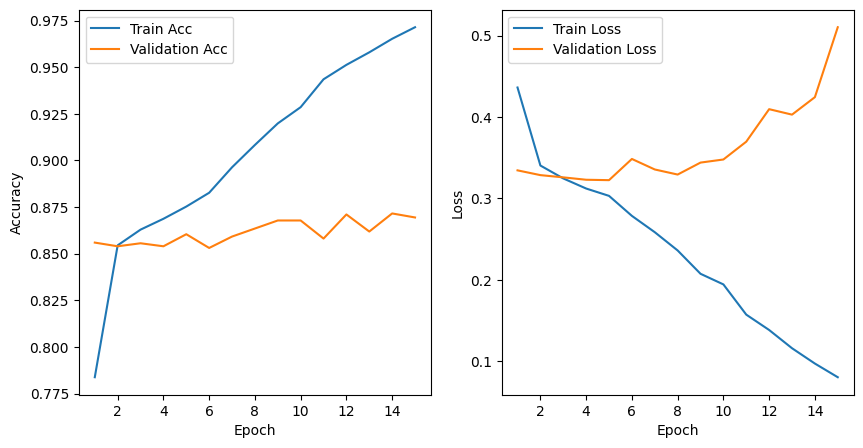

In [43]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

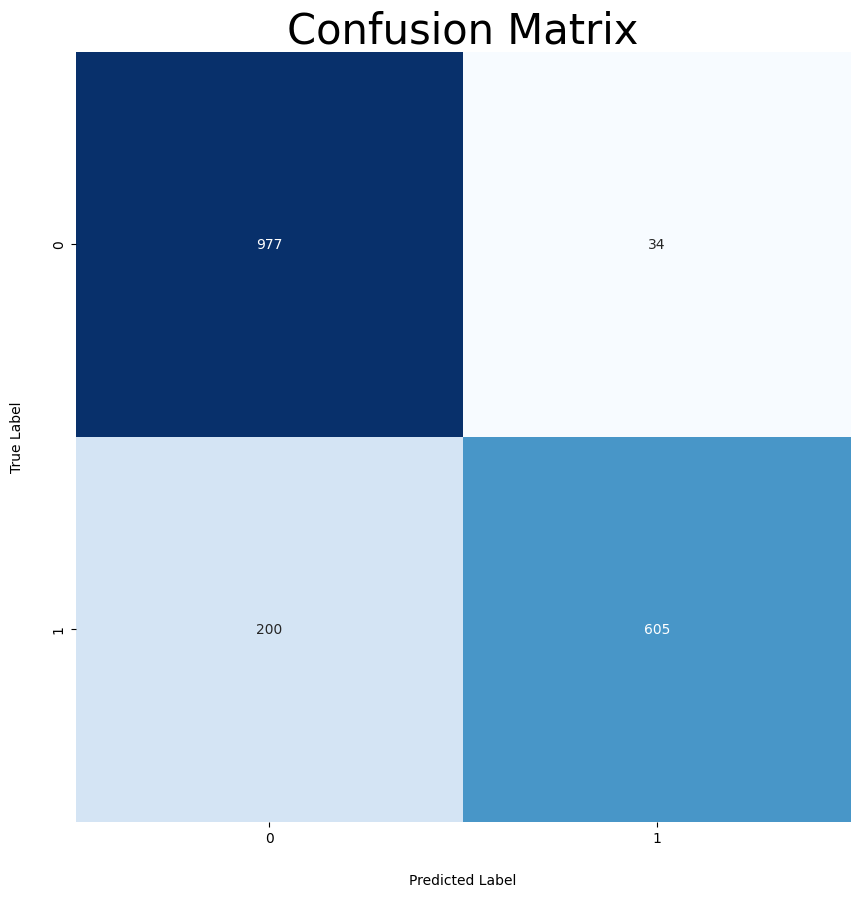

In [44]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [45]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.859
F1:        0.866
Precision: 0.888
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1011
           1       0.95      0.75      0.84       805

    accuracy                           0.87      1816
   macro avg       0.89      0.86      0.87      1816
weighted avg       0.88      0.87      0.87      1816

